## Recipe Site Traffic - Predicting Popular Recipes

In the following report I have used 'we' instead of 'I' as it is more convenient to explain.

## Workflow:
### 1. Cleaning and Validation
### 2. Exploratory Data Analysis
### 3. Model Development
### 4. Model Evaluation
### 5. Business Metric
### 6. Summary

In [ ]:
import numpy as np
import pandas as pd

recipe = pd.read_csv('recipe_site_traffic_2212.csv')

## Cleaning and Validation

Assessing the dataset on an surface level

In [ ]:
print(recipe.head())
print(recipe.info())

   recipe  calories  carbohydrate  ...   category  servings high_traffic
0       1       NaN           NaN  ...       Pork         6         High
1       2     35.48         38.56  ...     Potato         4         High
2       3    914.28         42.68  ...  Breakfast         1          NaN
3       4     97.03         30.56  ...  Beverages         4         High
4       5     27.05          1.85  ...  Beverages         4          NaN

[5 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes

### recipe
    expected: Numeric, unique identifier of recipe

    observed: Numeric type, No null entries (since it contains not null count equal to total row count), but still duplicates may exist

    cleaning and validation performed: Check for duplicates (no duplicates)

In [ ]:
# Checking the duplicate count
print(recipe['recipe'].duplicated().sum())

0


### category

    expected: Character, type of recipe. Recipes are listed in one of ten possible groupings (Lunch/Snacks', 'Beverages', 'Potato', 'Vegetable', 'Meat', 'Chicken, 'Pork', 'Dessert', 'Breakfast', 'One Dish Meal')

    observed: Object type, may exist categories that are logically not sound
    
    cleaning and validation performed: Assigned the 'Chicken Breast' category to 'Chicken', data type conversion from object to category

In [ ]:
# Checking for unique categories
print(recipe['category'].unique())

['Pork' 'Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Chicken' 'Vegetable' 'Meat' 'Dessert']


Logically, assigning the category 'Chicken Breast' to 'Chicken' category.

In [ ]:
recipe.loc[recipe['category'] == 'Chicken Breast', 'category'] = 'Chicken'
recipe['category'] = recipe['category'].astype('category')
print(recipe['category'].unique())

['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken', 'Lunch/Snacks', 'Vegetable', 'Meat', 'Dessert']
Categories (10, object): ['Beverages', 'Breakfast', 'Chicken', 'Dessert', ..., 'One Dish Meal', 'Pork', 'Potato', 'Vegetable']


### servings
    expected: Numeric, number of servings for the recipe

    observed: No Null entry, data type is object (needs to be converted)

    cleaning and validation performed: removed the keyword ' as a snack' from a few rows, converted data type from object to integer

In [ ]:
# Checking the data distribution
print(recipe['servings'].value_counts())

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64


In [ ]:
# removing the extra keywords 'as a snack'
recipe['servings'] = recipe['servings'].str.replace(' as a snack', '')
recipe['servings'] = recipe['servings'].astype('int')
print(recipe['servings'].value_counts())

4    391
6    198
2    183
1    175
Name: servings, dtype: int64


### high_traffic
    expected: Character, if the traffic to the site was high when this recipe was shown, this is marked with “High”.

    observed: 373 null entries (need to be imputed), data type is object (but needs to be converted for modeling purposes)

    cleaning and validation performed: nulls imputed with 0, the value 'High' replaced with 1, data type conversion from object to

In [ ]:
# checking for null entries
print(recipe['high_traffic'].isna().sum())

373


In [ ]:
# pd.get_dummies() will automatically convert the nulls to 0 and the rest to 1
recipe['high_traffic'] = pd.get_dummies(recipe['high_traffic'])

# checking converted column
print(recipe['high_traffic'].info())
print(recipe['high_traffic'].value_counts())

<class 'pandas.core.series.Series'>
RangeIndex: 947 entries, 0 to 946
Series name: high_traffic
Non-Null Count  Dtype
--------------  -----
947 non-null    uint8
dtypes: uint8(1)
memory usage: 1.0 KB
None
1    574
0    373
Name: high_traffic, dtype: int64


In [ ]:
print(recipe.iloc[:, 1:5].describe())

          calories  carbohydrate       sugar     protein
count   895.000000    895.000000  895.000000  895.000000
mean    435.939196     35.069676    9.046547   24.149296
std     453.020997     43.949032   14.679176   36.369739
min       0.140000      0.030000    0.010000    0.000000
25%     110.430000      8.375000    1.690000    3.195000
50%     288.550000     21.480000    4.550000   10.800000
75%     597.650000     44.965000    9.800000   30.200000
max    3633.160000    530.420000  148.750000  363.360000


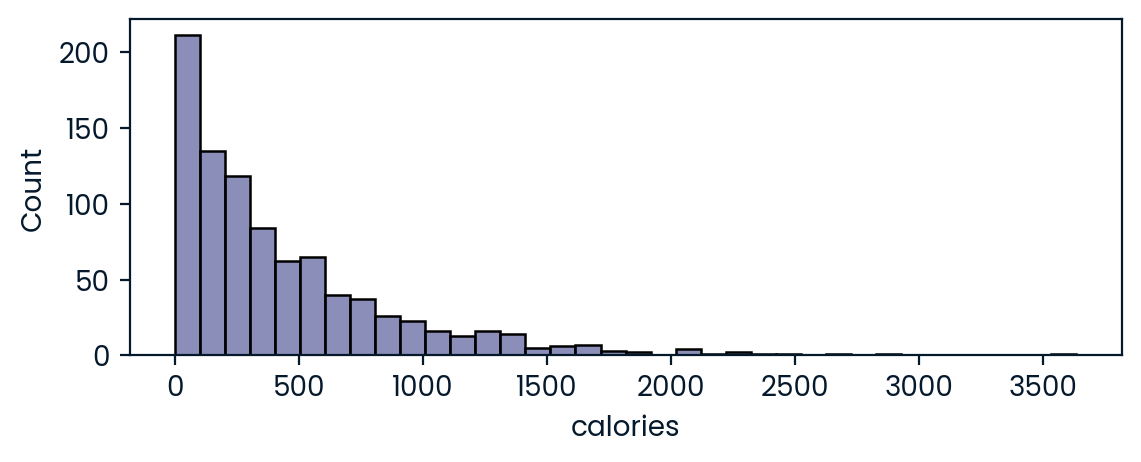

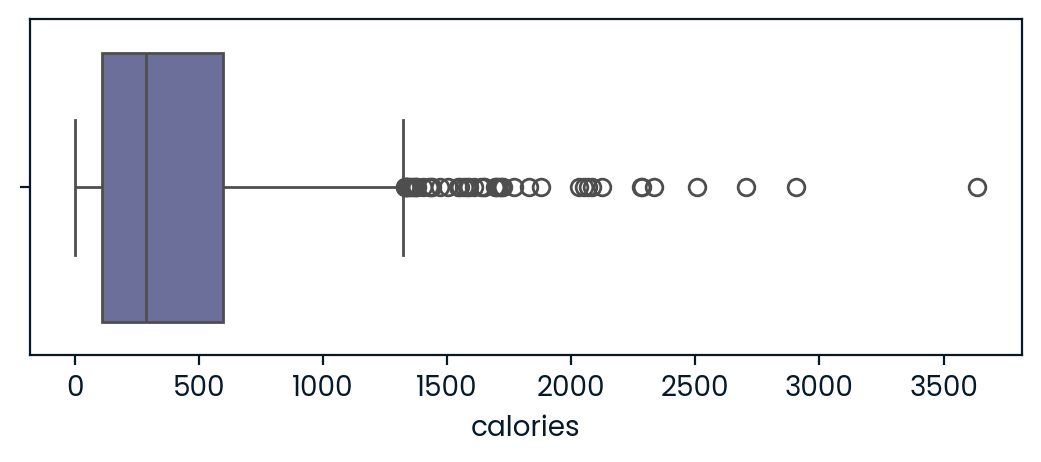

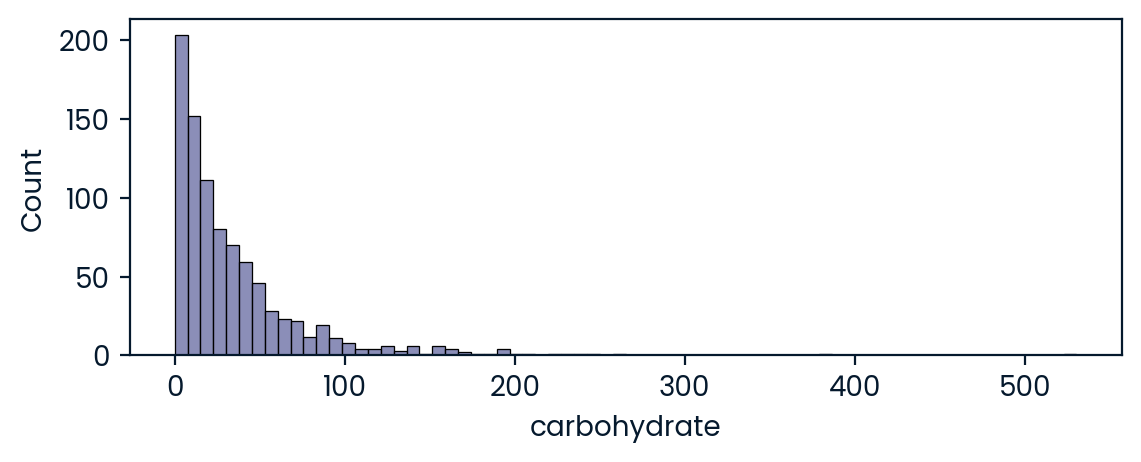

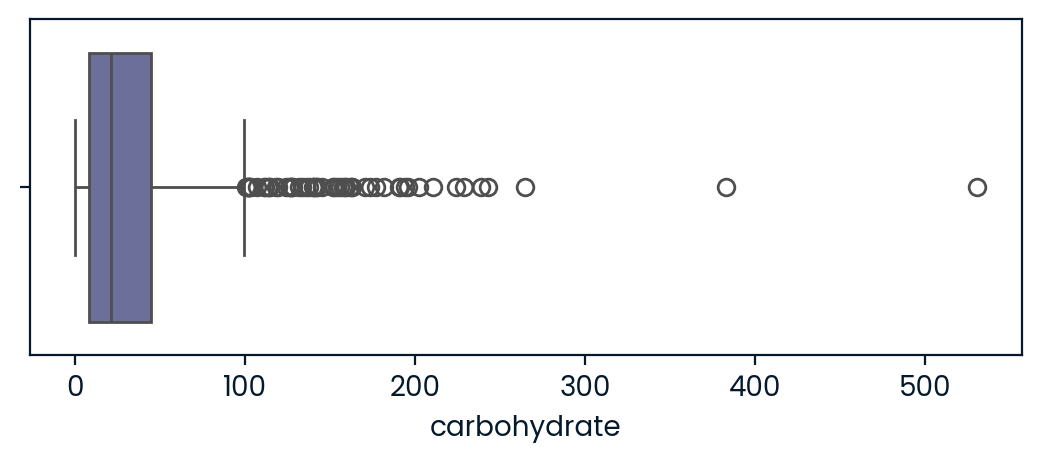

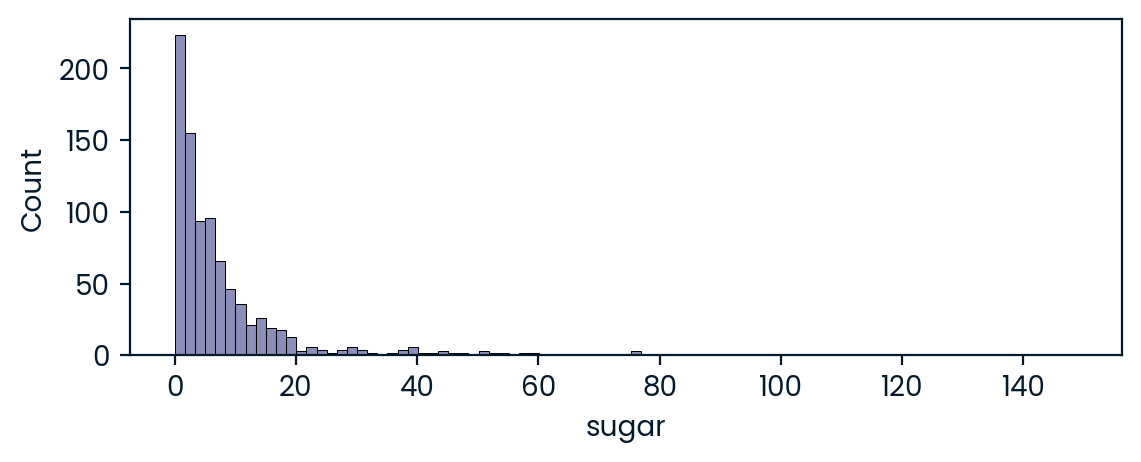

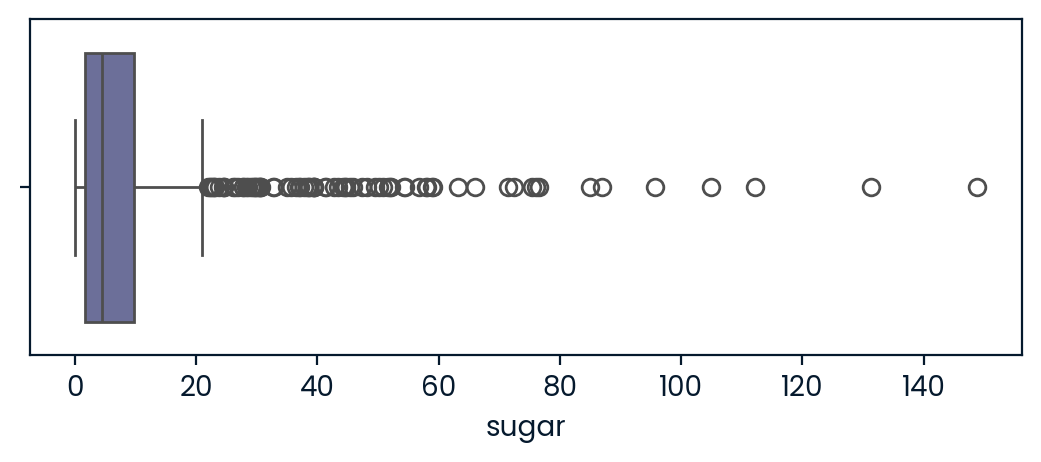

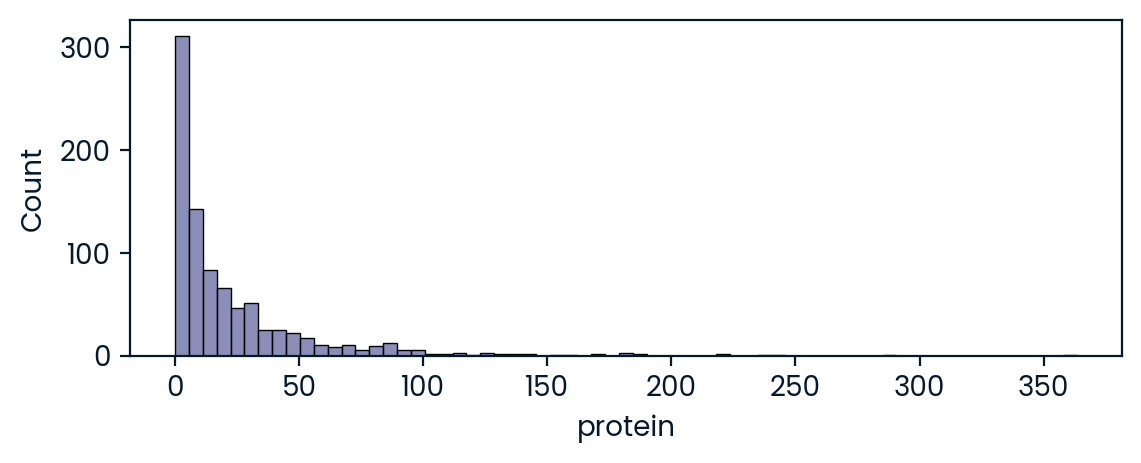

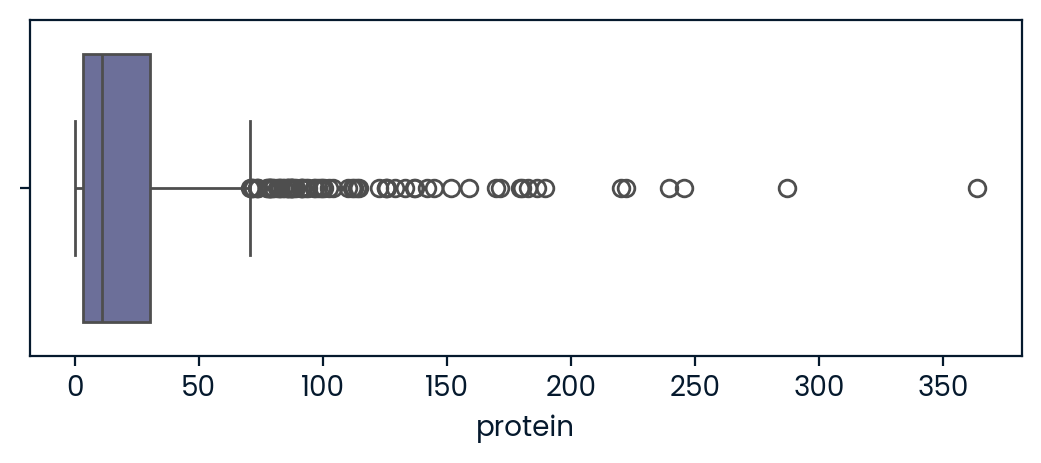

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in recipe.iloc[:, 1:5].columns:
    plt.subplot(2, 1, 1)
    sns.histplot(data=recipe, x=col)
    plt.show()
    plt.subplot(2, 1, 2)
    sns.boxplot(data=recipe, x=col)
    plt.show()
    plt.tight_layout()

For EDA I will retain th original values in a separate copied dataset at this point

In [ ]:
recipe_eda = recipe.copy()

Since the distributions of the nutrients columns are highly right skewed, therefore a normalization is required.

Since protein column also contain 0, therefore standard box-cox transformation will not work so here I use yeo-johnson transformation for normality in data.

The transformation and stadardization will be done before the data is imputed.

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson', standardize=True)
standard_df = pt.fit_transform(recipe.iloc[:, 1:5])
recipe.iloc[:, 1:5] = pd.DataFrame(standard_df, columns=recipe.iloc[:, 1:5].columns)

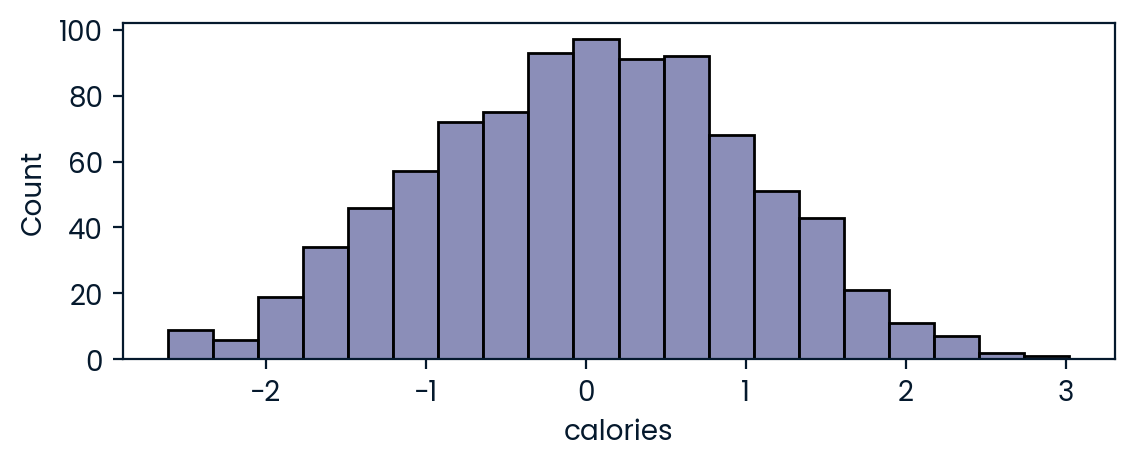

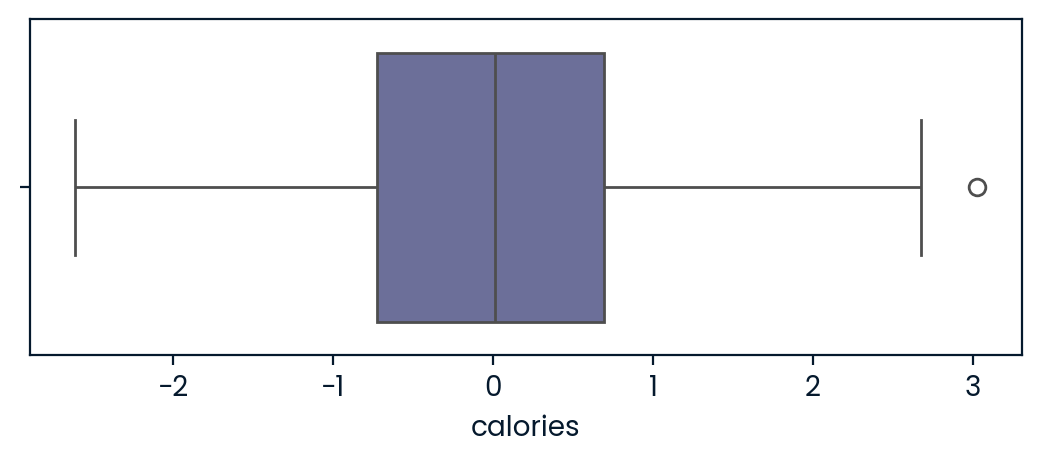

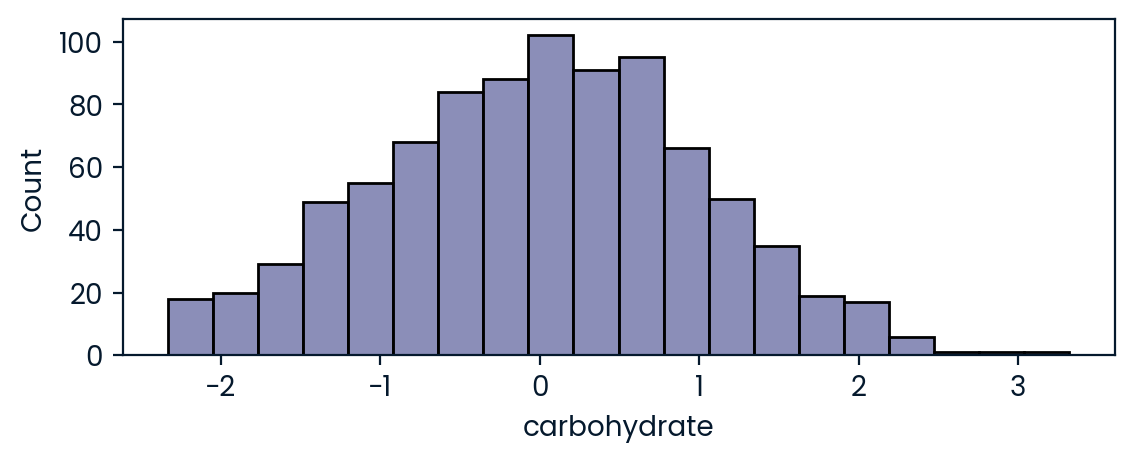

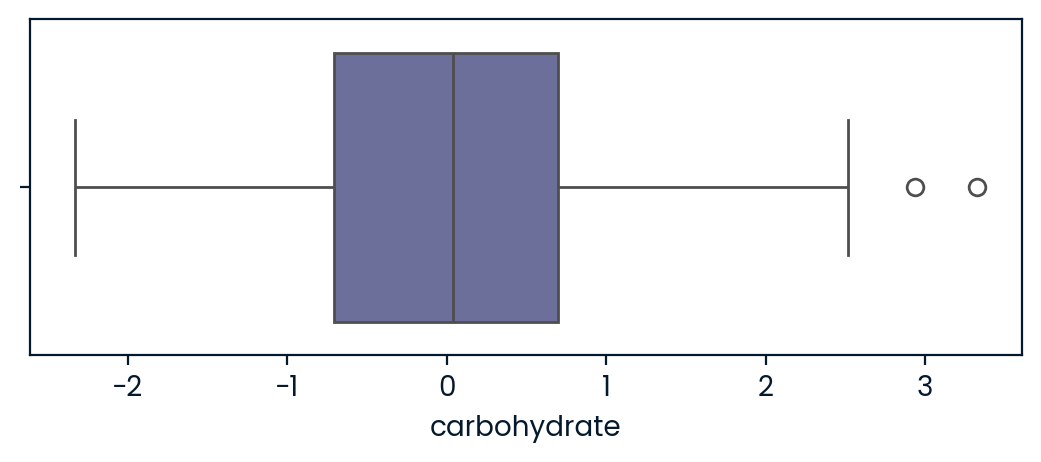

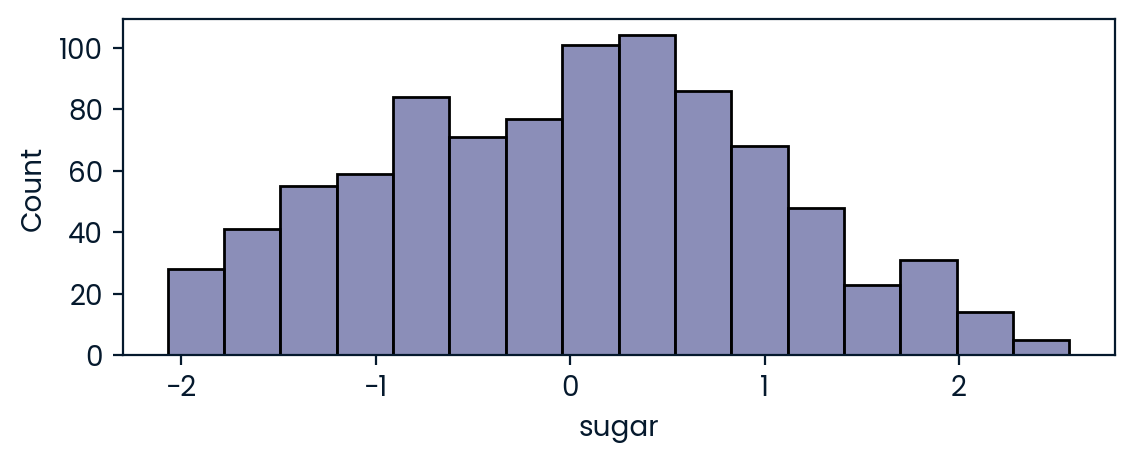

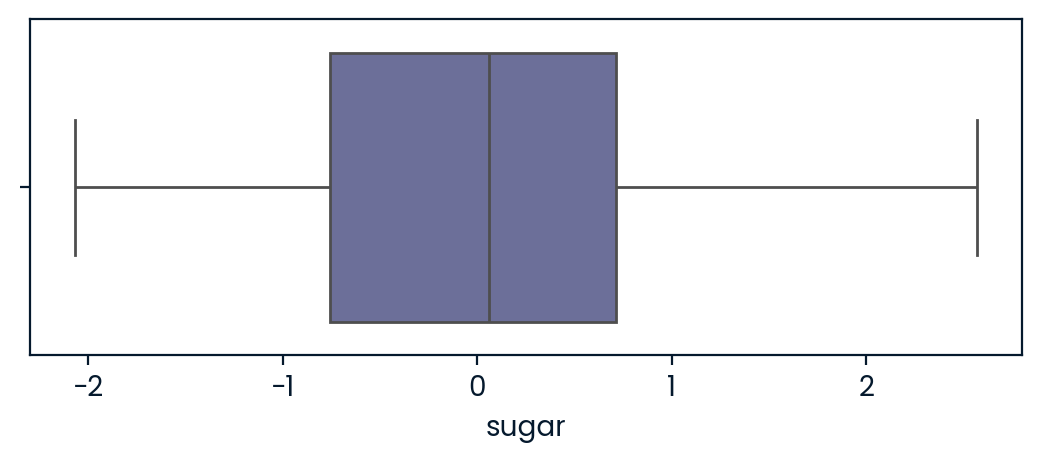

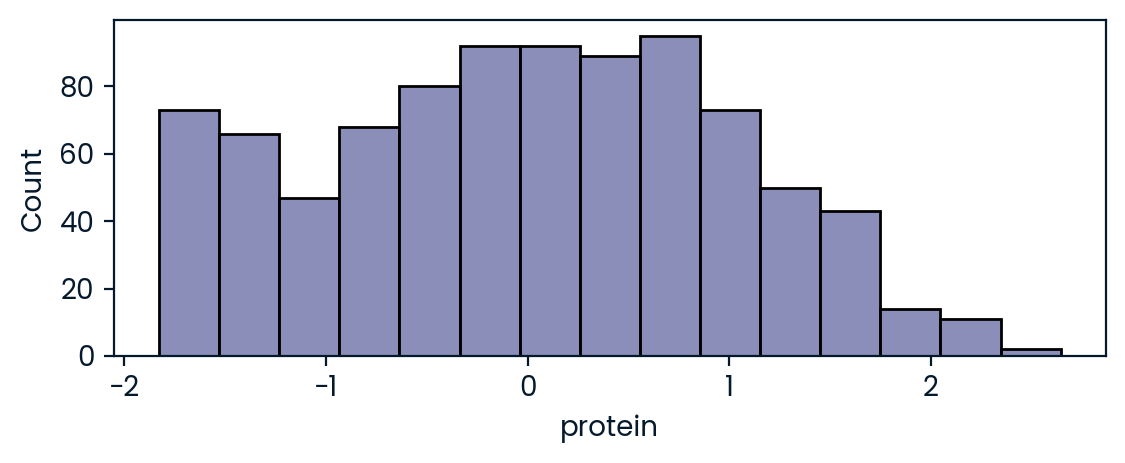

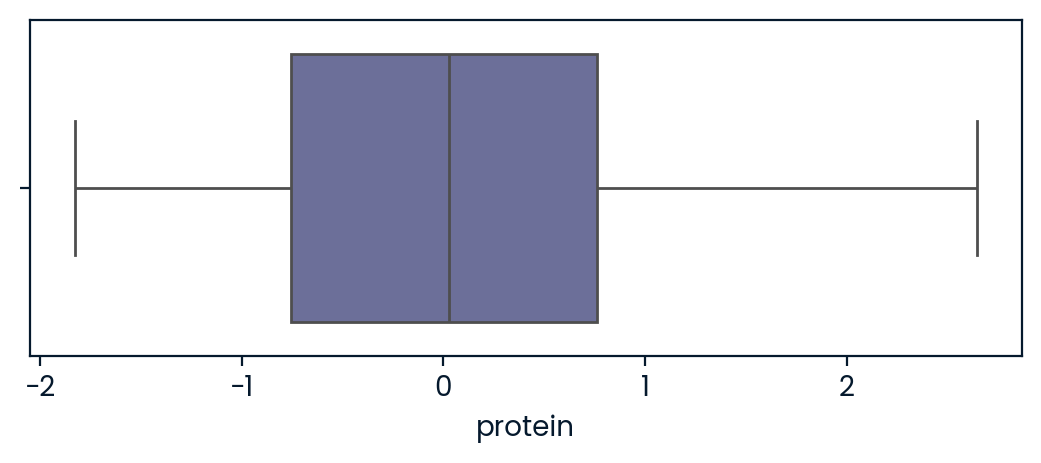

<Figure size 640x480 with 0 Axes>

In [ ]:
for col in recipe.iloc[:, 1:5].columns:
    plt.subplot(2, 1, 1)
    sns.histplot(data=recipe, x=col)
    plt.show()
    plt.subplot(2, 1, 2)
    sns.boxplot(data=recipe, x=col)
    plt.show()
    plt.tight_layout()

Now the data has been nicely normalized! We can now perform further column wise cleaning.

### calories
    expected: Numeric, number of calories

    observed: 52 null entries, data type numeric, significant outliers may be present

    cleaning and validation performed: Imputed null values group-wise ('category', 'servings'), outlier check (no significant outliers, higher values correspond to higher recipe serving sizes)

In [ ]:
def get_outliers(df, col):
    lower = -3
    upper = 3
    return (df[(df[col] < lower) | (df[col] > upper)].loc[:, ['recipe', 'servings', col]])

In [ ]:
# outlier check, checking if any exists, if exists then they are good or bad
print(get_outliers(recipe, 'calories'))

     recipe  servings  calories
925     926         4  3.023147


Since the value of calories is for a meal of serving size 4 then it is understandable to be a bit on a higher end.

In [ ]:
# null check
print(recipe['calories'].isna().sum())

52


Too many null entries, so imputing them with mean of the recipe from categorical and serving size dimensions (Group-wise).

In [ ]:
recipe['calories'] = recipe.groupby(['category', 'servings'])['calories'].transform(lambda x: x.fillna(x.mean()))
print(recipe['calories'].isna().sum())

0


### carbohydrate
    expected: Numeric, amount of carbohydrates in grams

    observed: 52 null entries, data type numeric, significant outliers may be present

    cleaning and validation performed: Imputed null values group-wise ('category', 'servings'), outlier check (no significant outliers, higher values correspond to higher recipe serving sizes)

In [ ]:
# outlier check, checking if any exists, if exists then they are good or bad
print(get_outliers(recipe, 'carbohydrate'))

     recipe  servings  carbohydrate
450     451         4      3.322237


The first row is good to go. Since the value of calories is for a meal of serving size 4 then it is understandable to be a bit on a higher end.

In [ ]:
# null check
print(recipe['carbohydrate'].isna().sum())

52


Too many null entries, so imputing them with mean of the recipe from categorical and serving size dimensions (Group-wise).

In [ ]:
recipe['carbohydrate'] = recipe.groupby(['category', 'servings'])['carbohydrate'].transform(lambda x: x.fillna(x.mean()))
print(recipe['carbohydrate'].isna().sum())

0


### sugar
    expected: Numeric, amount of sugar in grams

    observed: 52 null entries, data type numeric, significant outliers may be present

    cleaning and validation performed: Imputed null values group-wise ('category', 'servings'), outlier check (no significant outliers, higher values correspond to higher recipe serving sizes)

In [ ]:
# outlier check, checking if any exists, if exists then they are good or bad
print(get_outliers(recipe, 'sugar'))

Empty DataFrame
Columns: [recipe, servings, sugar]
Index: []


In [ ]:
# null check
print(recipe['sugar'].isna().sum())

52


Too many null entries, so imputing them with mean of the recipe from categorical and serving size dimensions (Group-wise).

In [ ]:
recipe['sugar'] = recipe.groupby(['category', 'servings'])['sugar'].transform(lambda x: x.fillna(x.mean()))
print(recipe['sugar'].isna().sum())

0


### protein
    expected: Numeric, amount of protein in grams

    observed: 52 null entries, data type numeric, significant outliers may be present

    cleaning and validation performed: Imputed null values group-wise ('category', 'servings'), outlier check (no significant outliers, higher values correspond to higher recipe serving sizes)

In [ ]:
# outlier check, checking if any exists, if exists then they are good or bad
print(get_outliers(recipe, 'protein'))

Empty DataFrame
Columns: [recipe, servings, protein]
Index: []


In [ ]:
# null check
print(recipe['protein'].isna().sum())

52


Too many null entries, so imputing them with mean of the recipe from categorical and serving size dimensions (Group-wise).

In [ ]:
recipe['protein'] = recipe.groupby(['category', 'servings'])['protein'].transform(lambda x: x.fillna(x.mean()))
print(recipe['protein'].isna().sum())

0


### After Cleaning and Validation

In [ ]:
print(recipe.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   recipe        947 non-null    int64   
 1   calories      947 non-null    float64 
 2   carbohydrate  947 non-null    float64 
 3   sugar         947 non-null    float64 
 4   protein       947 non-null    float64 
 5   category      947 non-null    category
 6   servings      947 non-null    int64   
 7   high_traffic  947 non-null    uint8   
dtypes: category(1), float64(4), int64(2), uint8(1)
memory usage: 46.7 KB
None


## Exploratory Data Analysis

### Overall View

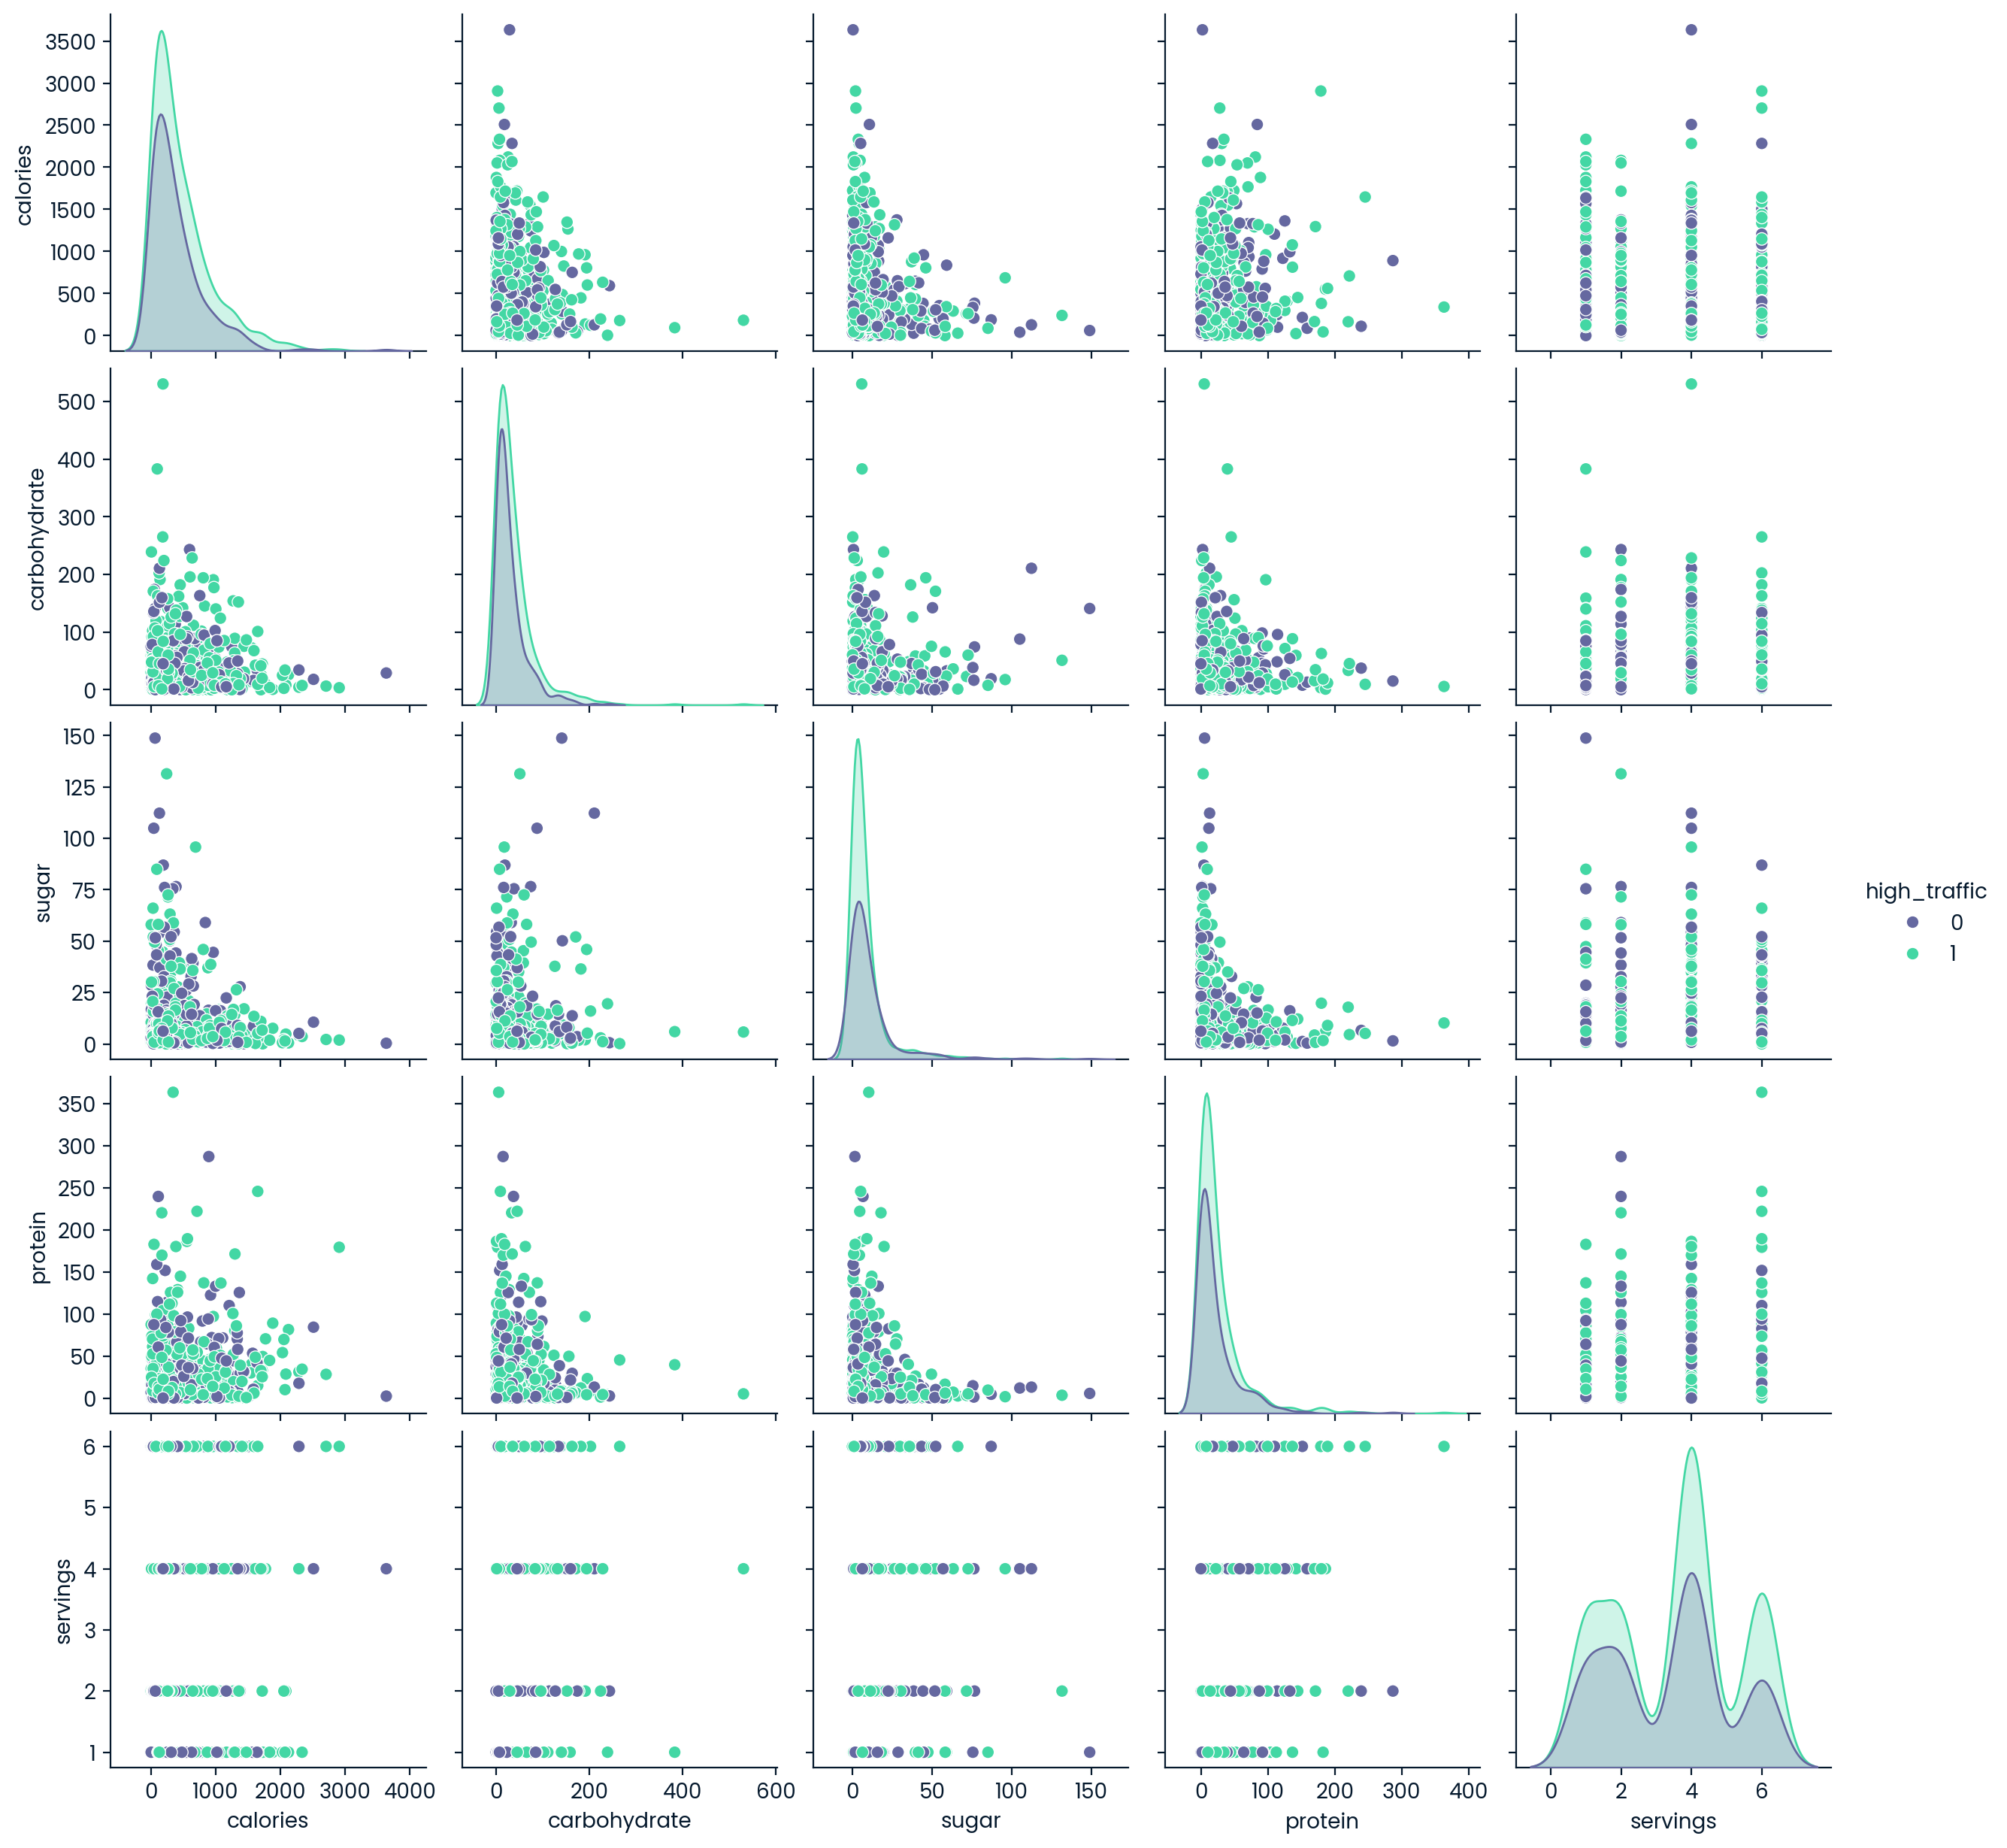

In [ ]:
sns.pairplot(data=recipe_eda.iloc[:, 1:], hue='high_traffic')
plt.show()

### Univariate Analysis

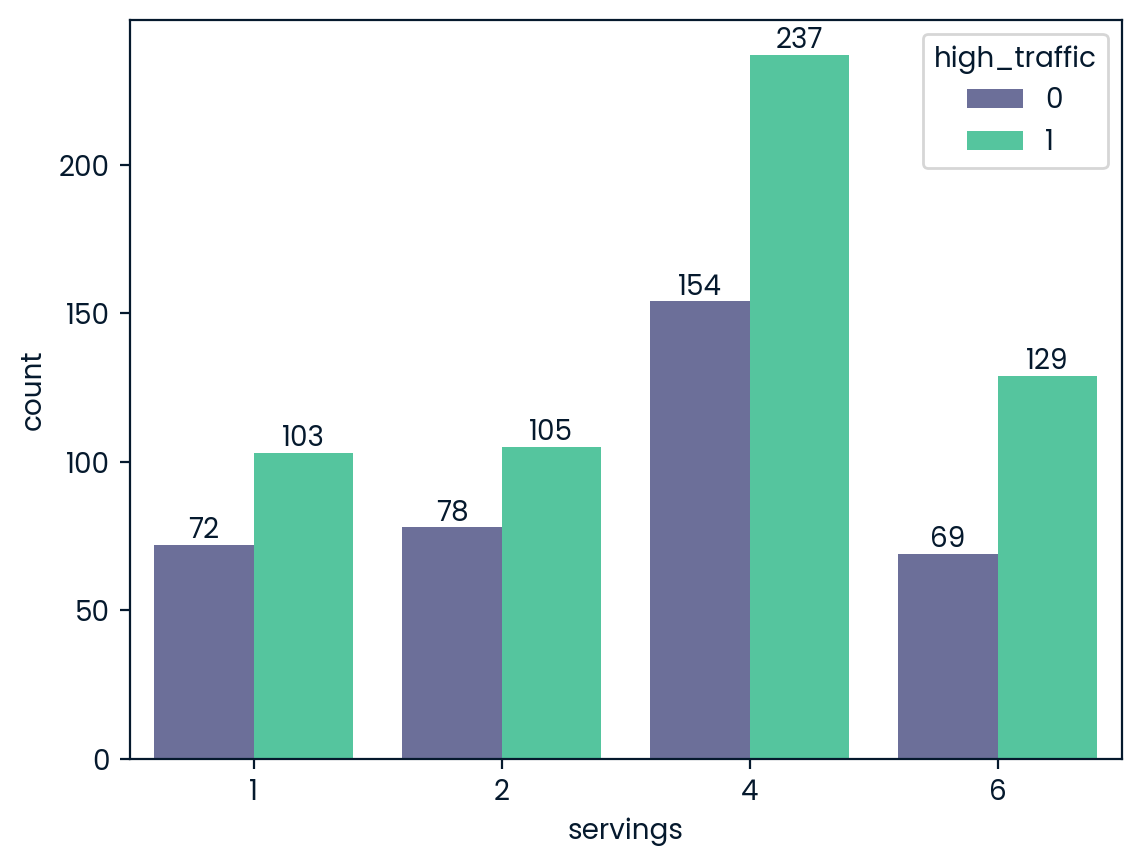

In [ ]:
ax = sns.countplot(data=recipe_eda, x='servings', hue='high_traffic')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

This tells that the meals with four servings are more popular than meals for other amount of servings.

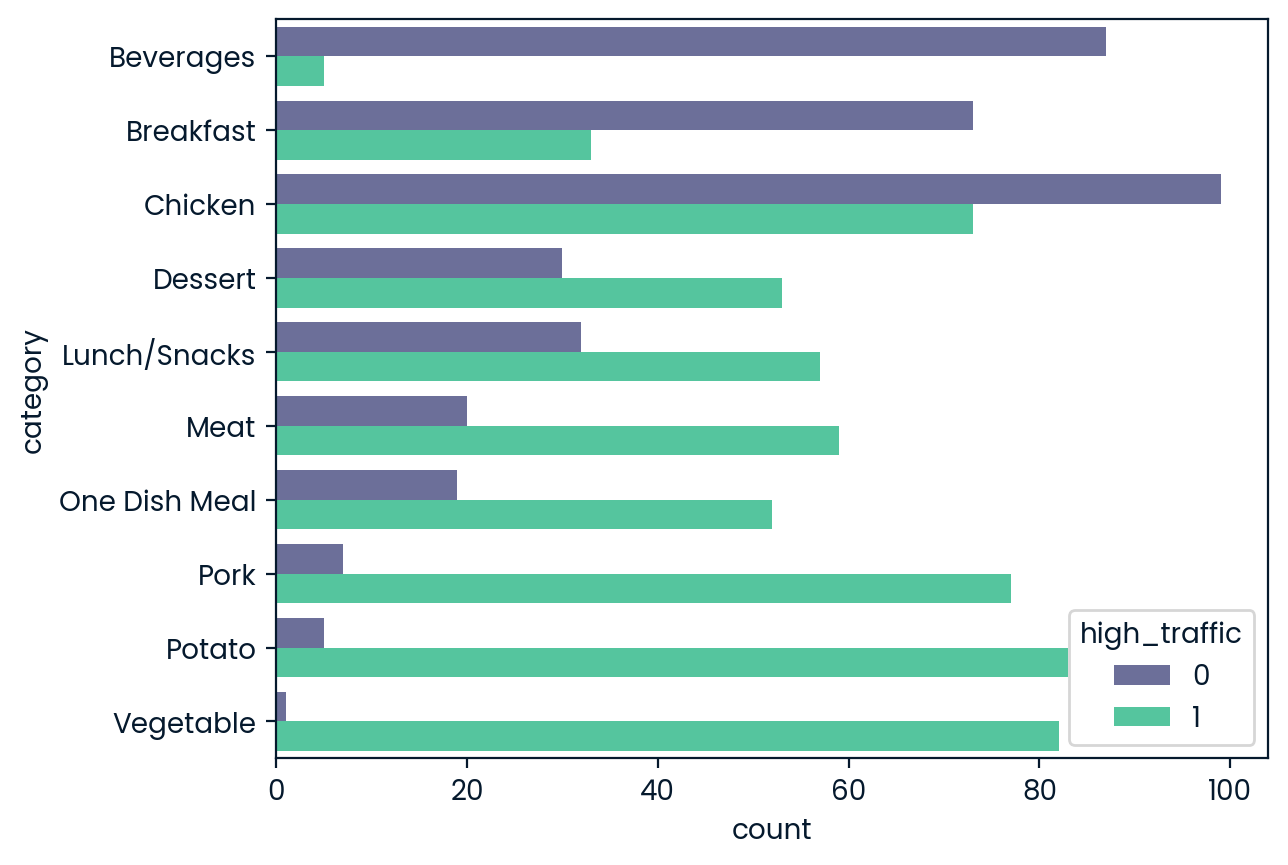

In [ ]:
sns.countplot(data=recipe, y='category', hue='high_traffic')
plt.show()

This shows that Potato, Pork and Vegetable categories are highly liked categories whereas Beverages and Breakfast gain very little traffic.

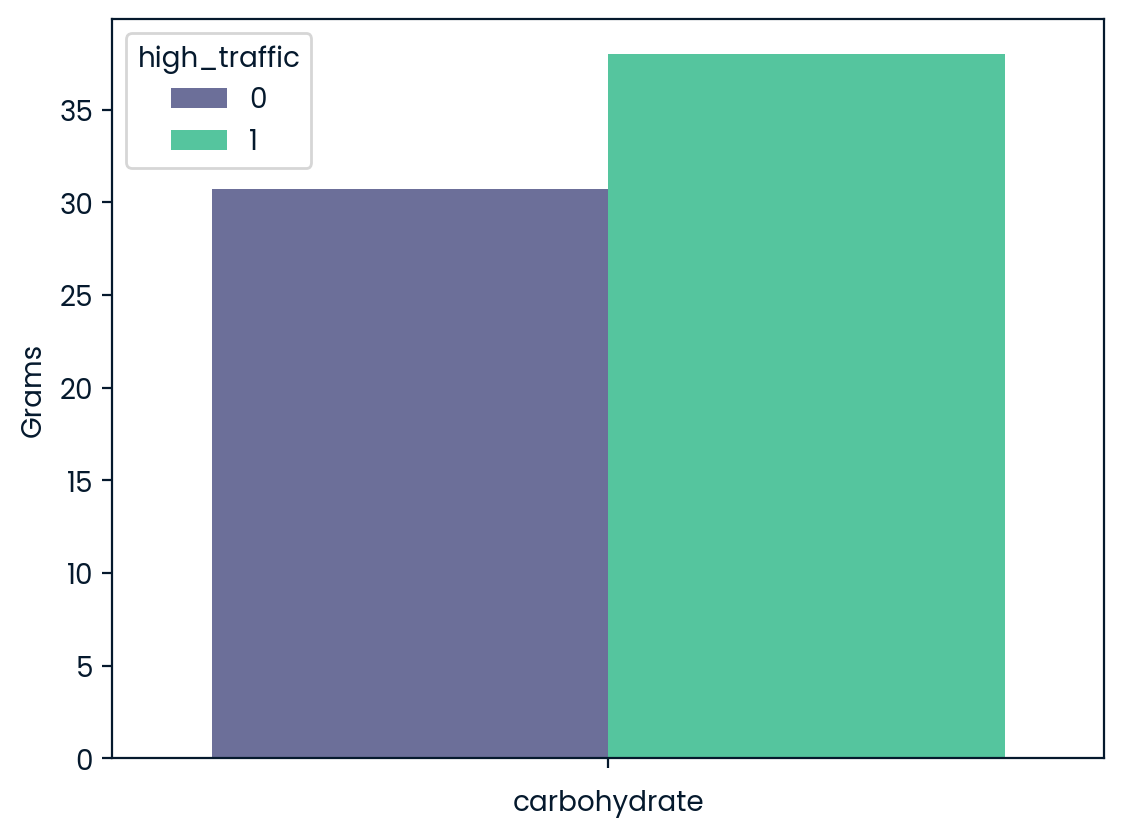

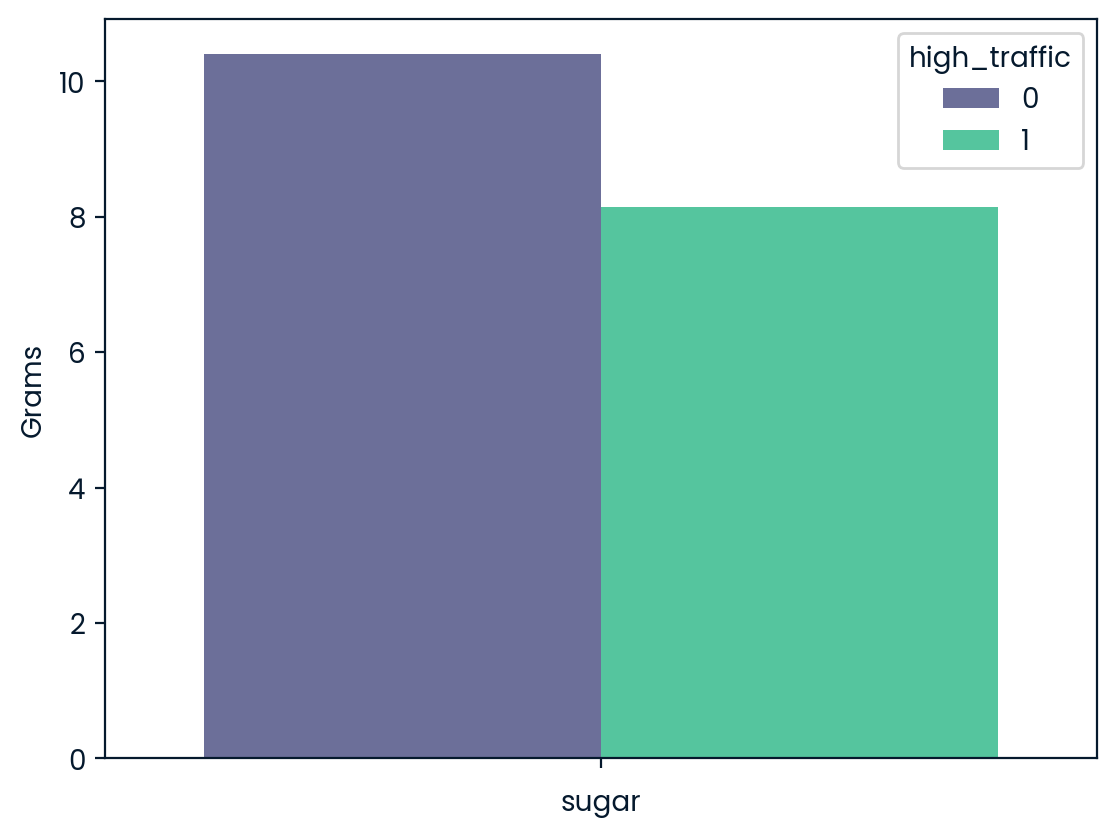

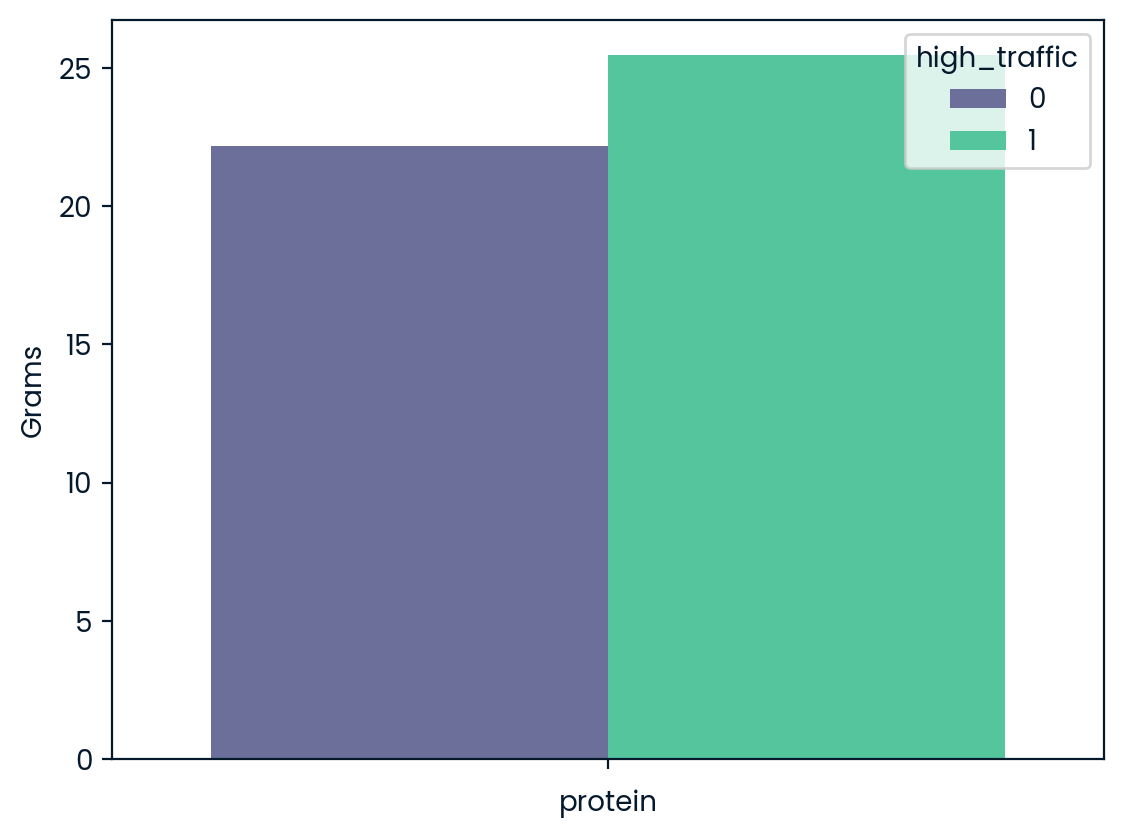

In [ ]:
for col in recipe.iloc[:, 2:5].columns:
    sns.barplot(y=recipe_eda[col], hue=recipe['high_traffic'], ci=None)
    plt.xlabel(col)
    plt.ylabel('Grams')
    plt.show()

On average per meal, there are more carbohydrates and proteins in popular meals than in unpopular meals, whereas on average per meal, there is more sugar in unpopular meals than in popular meals.

In other words carbohydrate-rich, protein-rich, and less-sugared meals are more preffered and this might be a factor as to why they are more popular.

### Multi-Variate Analysis

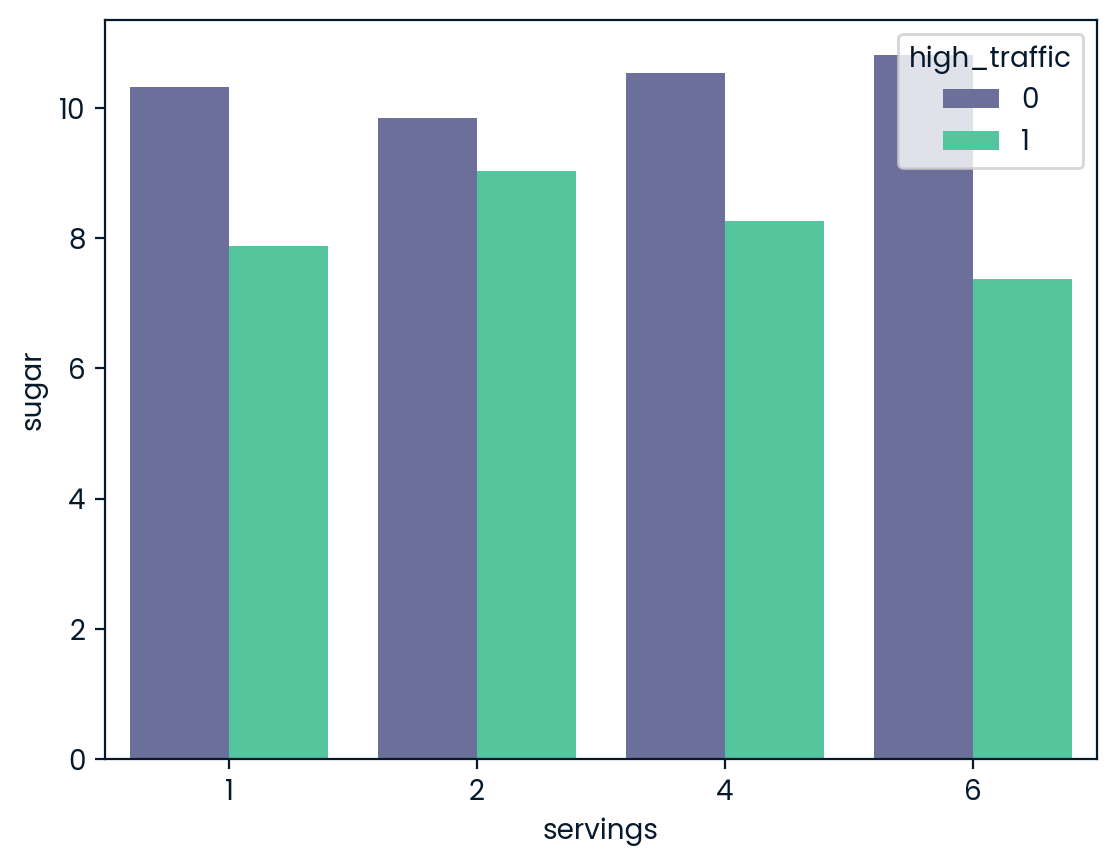

In [ ]:
sns.barplot(data=recipe_eda, x='servings', y='sugar', hue='high_traffic', ci=None)
plt.ylabel('sugar')
plt.show()

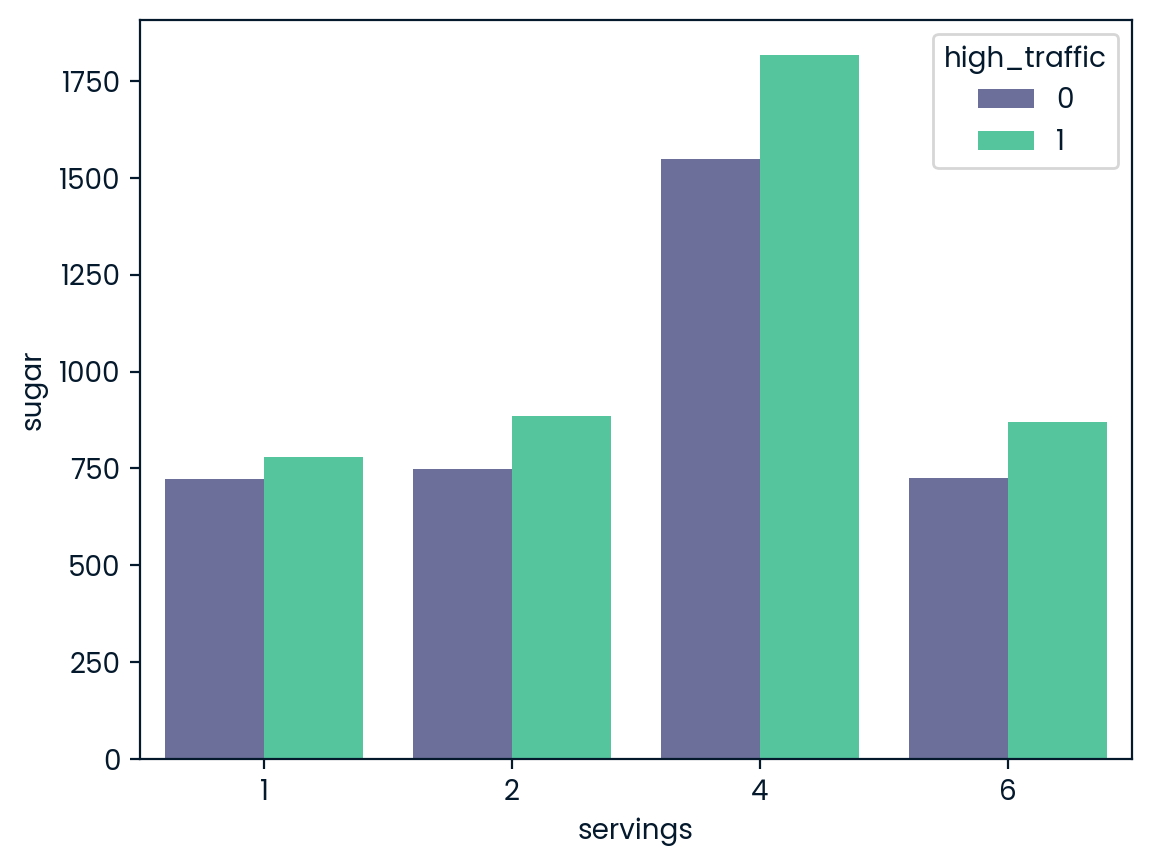

In [ ]:
sns.barplot(data=recipe_eda, x='servings', y='sugar', hue='high_traffic', ci=None, estimator='sum')
plt.ylabel('sugar')
plt.show()

Expanding on univariate analysis to check for the distribution of sugar in average per meal across amount of servings.

These graphs align with our previous observation of less sugar per meal on average in popular meals even though there are more popular meals than unpopular meals in the data.
And this result is true across meals of different serving amounts.

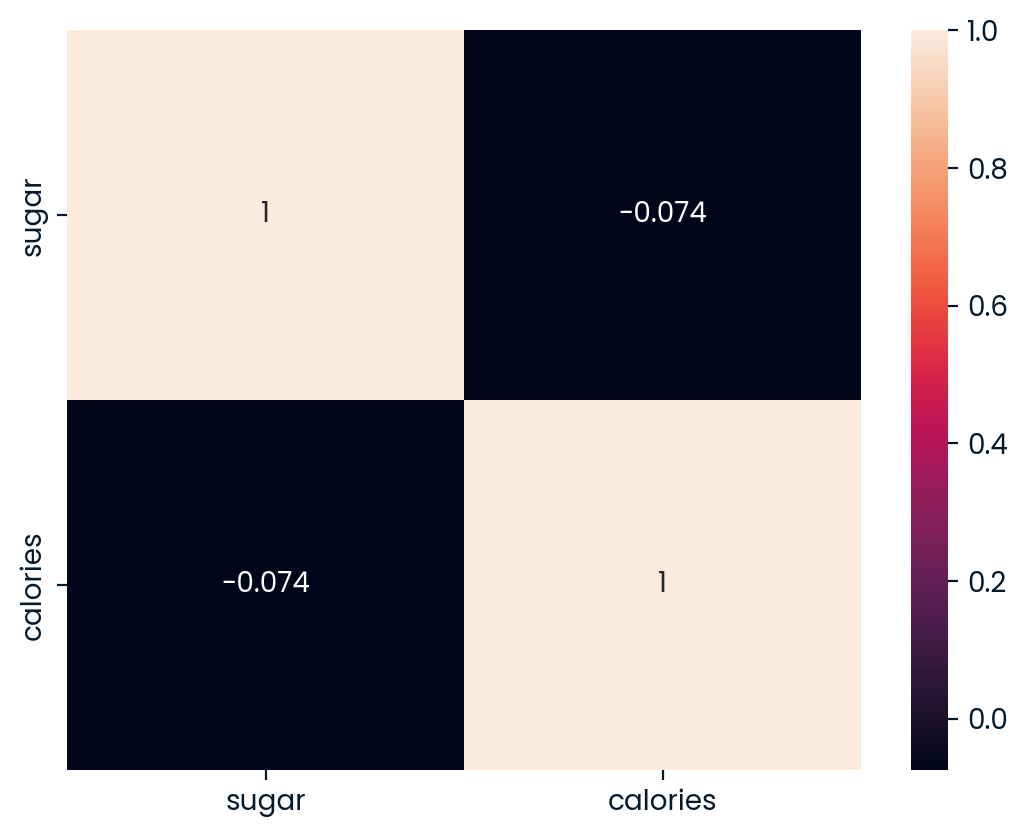

[]

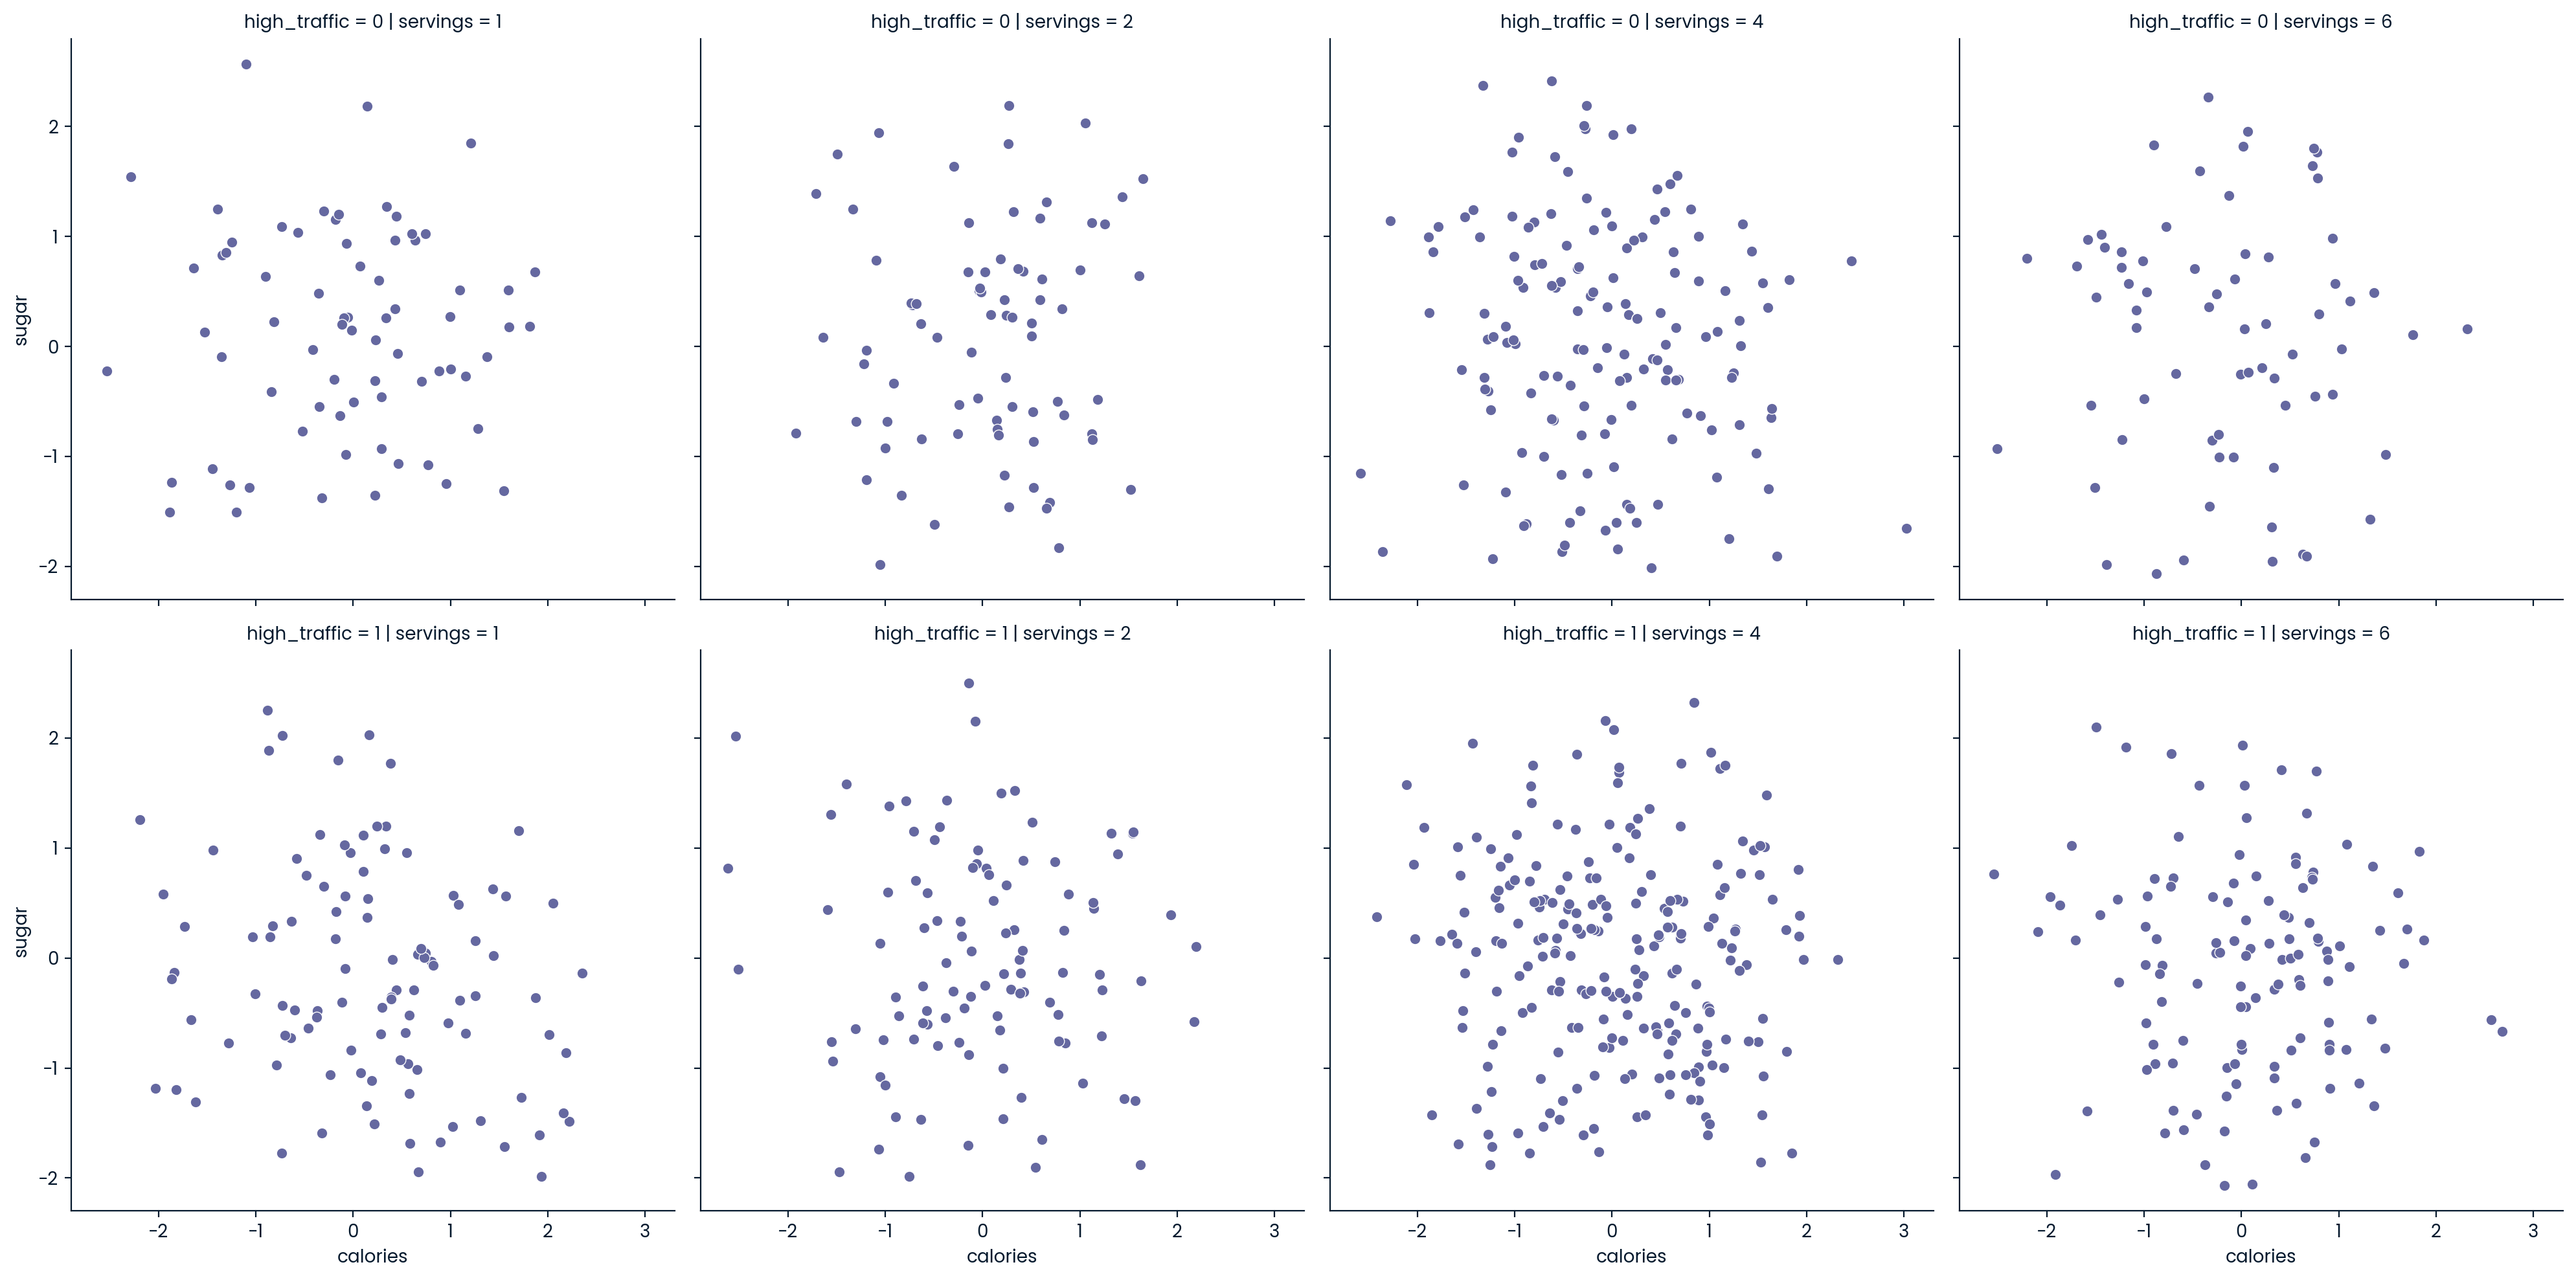

In [ ]:
sns.heatmap(recipe[['sugar', 'calories']].corr(), annot=True)
plt.show()
sns.relplot(kind='scatter', data=recipe, x='calories', y='sugar', row='high_traffic', col='servings')
plt.plot()

There is no strong association between sugar and calories even when distributed across amount of servings and high_traffic.


### Findings
- The meals with four servings are more popular than meals for other amount of servings.
- Potato, Pork and Vegetable categories are highly liked categories whereas Beverages and Breakfast categories gain very little traffic.
- Carbohydrate-rich, protein-rich, and less-sugary meals are more preffered and this might be a factor as to why they are more popular.
- Even though there are more popular meals than unpopular meals in the data there is less sugar per meal on average in popular meals. And this result is also true across meals of different serving amounts.
- There is no strong association between sugar and calories even when distributed across amount of servings and high_traffic.

## Model Development

Our goal is to correctly predict recipes which will be popular 80% of the time.

In other words, the precision of the model should be atleast 80%.

Reason:
Since low recall will not negatively affect the business but low precision will so the primary indicator to look at is precision.

This is a classification problem.

We have to predict whether a recipe will be popular or not.

We choosing logistic regression as baseline model and random forest as the comparison model since our data is limited so neural networks, XGBoosting, Gradient boosting won't show optimal results.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

x = pd.concat([recipe[['calories', 'carbohydrate', 'sugar', 'protein', 'servings']], pd.get_dummies(recipe['category'], drop_first=True)], axis=1)
y = recipe['high_traffic']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)
log_reg = LogisticRegression(max_iter=2000)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

In [ ]:
log_reg.fit(x_train, y_train)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

## Model Evaluation

Key:
- opt = optimal
- rf = random forest
- log_reg = logistic regression

In [ ]:
predicted_log_reg = log_reg.predict(x_test)
predicted_prob_log_reg = log_reg.predict_proba(x_test)[:, 1]
predicted_rf = rf.predict(x_test)

Optimal threshold:0.56


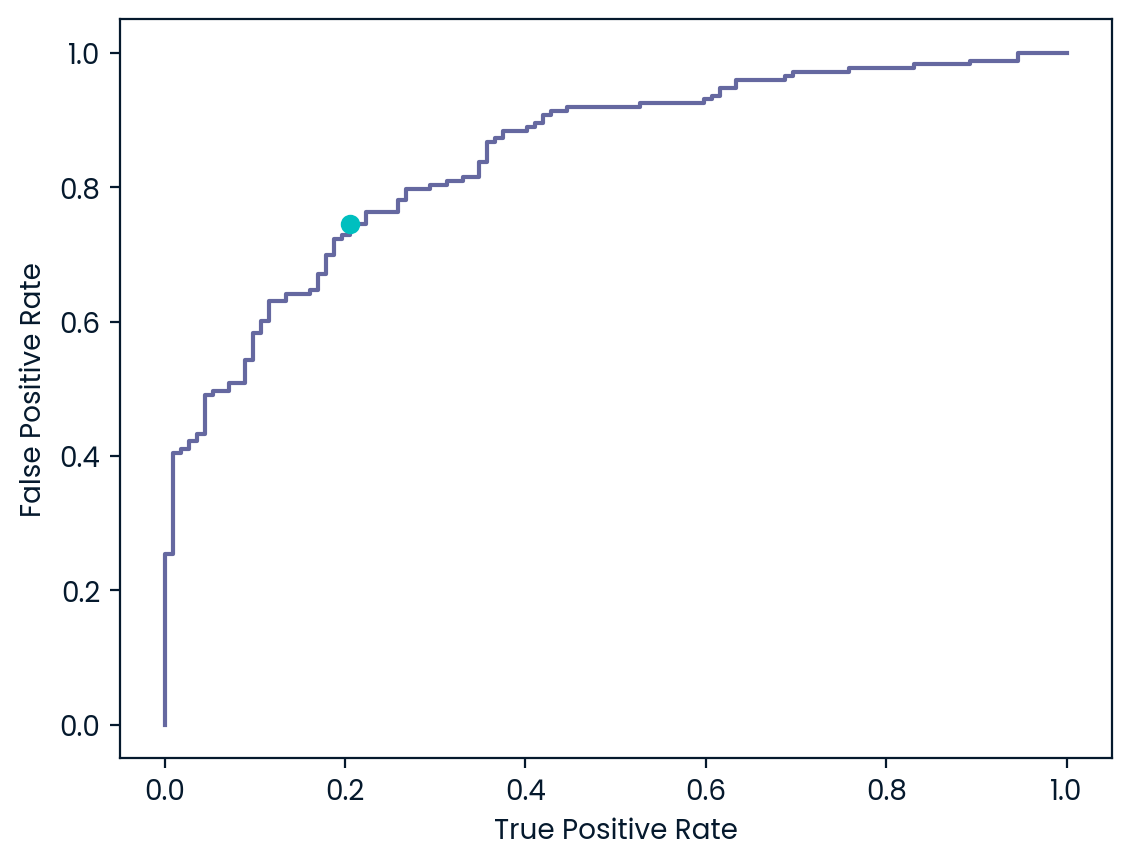

In [ ]:
from sklearn.metrics import roc_curve
from numpy import argmax

fpr, tpr, thresholds = roc_curve(y_test, predicted_prob_log_reg)

# to get the tangent point for optimal values
opt_idx = argmax(tpr-fpr)
opt_thresh = thresholds[opt_idx]
opt_fpr, opt_tpr = fpr[opt_idx], tpr[opt_idx]
plt.plot(fpr, tpr, label='roc_curve')
plt.plot(opt_fpr, opt_tpr, 'co')
plt.xlabel('True Positive Rate')
plt.ylabel('False Positive Rate')
print(f'Optimal threshold:{opt_thresh:.2f}')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [50, 100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2'], 'bootstrap':[True, False]}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', verbose=2, n_jobs=-1, cv=5)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimato

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy', verbose=2)

In [ ]:
print(f'Random Forest optimal parameters: {grid_search.best_params_}')

rf_best = grid_search.best_estimator_

predicted_rf_opt = rf_best.predict(x_test)

Random Forest optimal parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
from sklearn.metrics import classification_report

predicted_log_reg_opt = (predicted_prob_log_reg >= opt_thresh).astype(int)

print('On Test Data')
print('Baseline Model: Logistic Regression')
print(f'By default threshold: {0.5}')
print(classification_report(y_test, predicted_log_reg))

print(f'By optimal threshold: {opt_thresh:.2}')
print(classification_report(y_test, predicted_log_reg_opt))

print('Comparison Model: Random Forest')
print(f'By Default Parameters')
print(classification_report(y_test, predicted_rf))

print(f'By Optimal Parameters')
print(classification_report(y_test, predicted_rf_opt))

On Test Data
Baseline Model: Logistic Regression
By default threshold: 0.5
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       112
           1       0.82      0.78      0.80       173

    accuracy                           0.76       285
   macro avg       0.75      0.76      0.76       285
weighted avg       0.77      0.76      0.77       285

By optimal threshold: 0.56
              precision    recall  f1-score   support

           0       0.67      0.79      0.73       112
           1       0.85      0.75      0.79       173

    accuracy                           0.76       285
   macro avg       0.76      0.77      0.76       285
weighted avg       0.78      0.76      0.77       285

Comparison Model: Random Forest
By Default Parameters
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       112
           1       0.78      0.77      0.78       173

    accuracy              

In [ ]:
print('For the model performing best on test data we compare it with the model performance on train data')

predicted_prob_log_reg_train = log_reg.predict_proba(x_train)[:, 1]
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, predicted_prob_log_reg_train)

train_opt_idx = argmax(train_tpr - train_fpr)
train_opt_thresh = train_thresholds[train_opt_idx]

predicted_log_reg_opt_train = (predicted_prob_log_reg_train >= train_opt_thresh).astype(int)

print('Baseline Model: Logistic Regression')
print(f'By optimal threshold: {opt_thresh:.2}')

print('Test Data Report')
print(classification_report(y_test, predicted_log_reg_opt))

print('Train Data Report')
print(classification_report(y_train, predicted_log_reg_opt_train))

For the model performing best on test data we compare it with the model performance on train data
Baseline Model: Logistic Regression
By optimal threshold: 0.56
Test Data Report
              precision    recall  f1-score   support

           0       0.67      0.79      0.73       112
           1       0.85      0.75      0.79       173

    accuracy                           0.76       285
   macro avg       0.76      0.77      0.76       285
weighted avg       0.78      0.76      0.77       285

Train Data Report
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       261
           1       0.80      0.81      0.80       401

    accuracy                           0.76       662
   macro avg       0.75      0.75      0.75       662
weighted avg       0.76      0.76      0.76       662



Now checking using cross validation for better validation and generalization of the model

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(log_reg, x, y, cv=kf, scoring='accuracy')

In [ ]:
from numpy import mean
print(f'Cross Validation Scores for each fold:{scores}')
print(f'Mean Cross-Validation Score: {mean(scores):.2}')

Cross Validation Scores for each fold:[0.82105263 0.76842105 0.75789474 0.75789474 0.73684211 0.74736842
 0.66315789 0.73404255 0.81914894 0.77659574]
Mean Cross-Validation Score: 0.76


This is very close to train and test data model accuracy scores, this means that the model is quite nicely generalized.

## Business Metric

Our business is negatively affected by if the model predicts a recipe as high_traffic but in reality it is not a high traffic recipe (In other words, a False Positive (FP)) and is positively affected if the model correctly predicts the high_traffic recipes (In other words, a True Positive (TP)).

Therefore the KPI must be such that the FP count minimizes and TP count maximizes.

For this we can set up a ratio of (FP/TP) which we can call "True High Traffic Recipe Index (THTRI)" for the model prediction evaluation.

Now for calulating baseline value for this index we can use our logistic regression model values

In [ ]:
from sklearn.metrics import confusion_matrix

con_mat_train = confusion_matrix(y_train, predicted_log_reg_opt_train)
con_mat_test = confusion_matrix(y_test, predicted_log_reg_opt)

print('Logistic Regression: Train: True High Traffic Recipe Index:', con_mat_train[1, 1]/con_mat_train[0, 1])
print('Logistic Regression: Test: True High Traffic Recipe Index:', con_mat_test[1, 1]/con_mat_test[0, 1])

rf_con_mat_test = confusion_matrix(y_test, predicted_rf_opt)

print('Random Forest: True High Traffic Recipe Index:', rf_con_mat_test[1, 1]/rf_con_mat_test[0, 1])

Logistic Regression: Train: True High Traffic Recipe Index: 3.9634146341463414
Logistic Regression: Test: True High Traffic Recipe Index: 5.608695652173913
Random Forest: True High Traffic Recipe Index: 4.387096774193548


Since the value of the True High Traffic Recipe Index (THTRI) for the Random Forest Model is barely 4.5 and for Logistic Regression Model it is higher than 4.5, especially on test dataset, therefore we can set the benchmark at THTRI = 4.5 as a business monitoring KPI

## Summary
Through extensive data cleaning and validation to exploratory data analysis to model development and evaluation, we gained the following insights:
- The meals with four servings are more popular than meals for other amount of servings.
- Potato, Pork and Vegetable categories are highly liked categories whereas Beverages and Breakfast categories gain very little traffic.
- Carbohydrate-rich, protein-rich, and less-sugary meals are more preffered and this might be a factor as to why they are more popular.
- Low precision negatively affects the business, therefore the model must have high precision after generalization.
- Optimized Logistic Regression performs better than optimized Random Forest due to nature of the given data for classifying whether a recipe will have high traffic or not.
- As a result, we established a ratio as a Key Performance Indicator (KPI) for monitoring business, True High Traffic Recipe Index (THTRI)
- By model evaluation and comparison, we set the ratio THTRI benchmark at 4.5

## Recommendations
Based on the above summary, following are the recommended actions:
- Recipes from Potato, Pork and Vegetable categories should be promoted for displaying on the website
- Only a select few Beverages and Breakfast category meals should be put up for display to make space for more popular recipes
- Carbohydrate-rich, protein-rich, and less-sugary meals have a higher chance of gaining high traffic, therefore in addition to selecting recipes from Potato, Pork, and Vegetable categories, having this filter would further increase the chances of high traffic
- Integration of the Optimized Logistic Regression Model with the suggested KPI for monitoring business (weekly) would help to generate high traffic on Tasty Bytes website